## Import libraries

In [25]:

import pyrealsense2 as rs
import numpy as np
import cv2
from matplotlib import pyplot as plt


## Add filters for depth image
https://github.com/IntelRealSense/librealsense/blob/jupyter/notebooks/depth_filters.ipynb


In [26]:
decimation = rs.decimation_filter()
decimation.set_option(rs.option.filter_magnitude, 4)

spatial = rs.spatial_filter()
spatial.set_option(rs.option.filter_magnitude, 5)
spatial.set_option(rs.option.filter_smooth_alpha, 1)
spatial.set_option(rs.option.filter_smooth_delta, 50)
spatial.set_option(rs.option.holes_fill, 3)

temporal = rs.temporal_filter()

hole_filling = rs.hole_filling_filter()

depth_to_disparity = rs.disparity_transform(True)
disparity_to_depth = rs.disparity_transform(False)


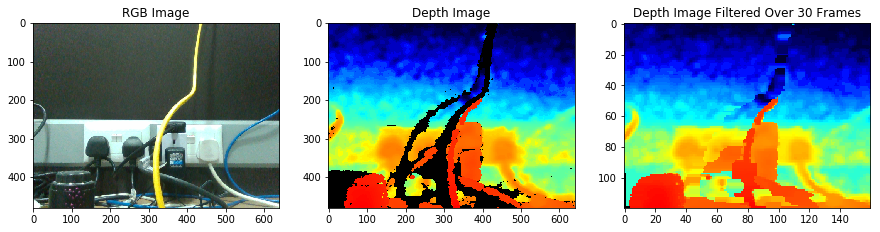

In [38]:
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
pipeline.start(config)

frame = None
depth_frame = None
color_frame = None
depth_frame_1 = None
frame_count = 0
align = rs.align(rs.stream.color)
colorizer = rs.colorizer()

# ignore the first few frames, to allow the camera auto-exposure to stabilise
while (frame_count < 30):
    frame = pipeline.wait_for_frames()
    frame_count += 1

frame_count = 0
while (not depth_frame or not color_frame) and (frame_count < 30):
    frame = pipeline.wait_for_frames()
    frame = align.process(frame)
    depth_frame = frame.get_depth_frame()
    color_frame = frame.get_color_frame()
    if (not depth_frame_1):
        depth_frame_1 = depth_frame
        depth_image_1 = np.asanyarray(depth_frame_1.get_data())
        colorized_depth_1 = np.asanyarray(colorizer.colorize(depth_frame_1).get_data())
    if (depth_frame):
        depth_frame = decimation.process(depth_frame)
        depth_frame = depth_to_disparity.process(depth_frame)
        depth_frame = spatial.process(depth_frame)
        depth_frame = temporal.process(depth_frame)
        depth_frame = disparity_to_depth.process(depth_frame)
        depth_frame = hole_filling.process(depth_frame)
    frame_count += 1
    

# Convert images to numpy arrays
depth_image = np.asanyarray(depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())

colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())

# Apply colormap on depth image (image must be converted to 8-bit per pixel first)
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

# Stop streaming
pipeline.stop()

# Stack both images horizontally
#images = np.hstack((color_image, colorized_depth))

# Show images
fig = plt.figure(figsize=(15, 15))
table1 = fig.add_subplot(1,3,1)
table1.set_title("RGB Image")
table1.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))

table2 = fig.add_subplot(1,3,2)
table2.set_title("Depth Image")
table2.imshow(cv2.cvtColor(colorized_depth_1, cv2.COLOR_BGR2RGB))

table3 = fig.add_subplot(1,3,3)
table3.set_title("Depth Image Filtered Over 30 Frames")
table3.imshow(cv2.cvtColor(colorized_depth, cv2.COLOR_BGR2RGB))



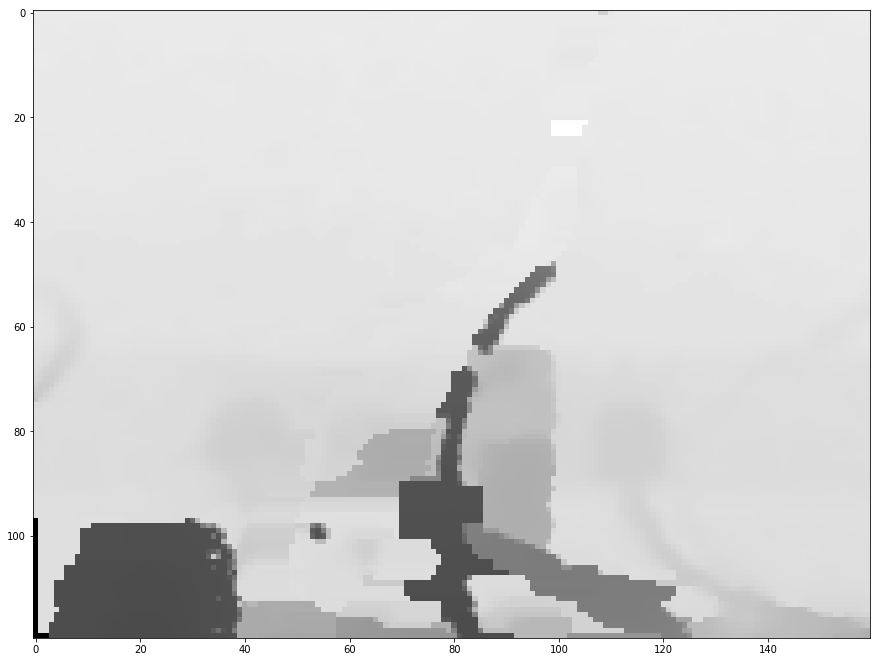

In [34]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(depth_image, cmap='gray')
plt.show()


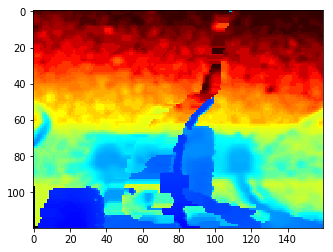

In [35]:
plt.imshow(colorized_depth)